In [2]:
%pip install matplotlib
%pip install numpy
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import os
import numpy as np

In [4]:
import pandas as pd
import os

def load_and_clean_timeseries(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No se encontró el archivo en: {file_path}")
    
    df = pd.read_csv(file_path)
    
    # --- EL CAMBIO ESTÁ AQUÍ ---
    # Convertimos directamente a numérico. Pandas detecta el punto como decimal por defecto.
    df['Demand'] = pd.to_numeric(df['Demand'], errors='coerce')
    # ---------------------------
    
    df['year_month'] = pd.to_datetime(df['year_month'])
    df = df.sort_values('year_month').reset_index(drop=True)
    
    return df

DATA_PATH = os.path.join('..', 'data', 'dataset_demand_acumulate.csv')
try:
    df_demand = load_and_clean_timeseries(DATA_PATH)
    print("Datos cargados y limpios exitosamente.")
    print(df_demand.head())
    print("\nTipos de datos:\n", df_demand.dtypes)
except Exception as e:
    print(f"Error: {e}")

Datos cargados y limpios exitosamente.
  year_month       Demand
0 2017-01-01  1211.009490
1 2017-02-01  1660.584649
2 2017-03-01  3182.587014
3 2017-04-01  3506.515270
4 2017-05-01  4554.082280

Tipos de datos:
 year_month    datetime64[ns]
Demand               float64
dtype: object


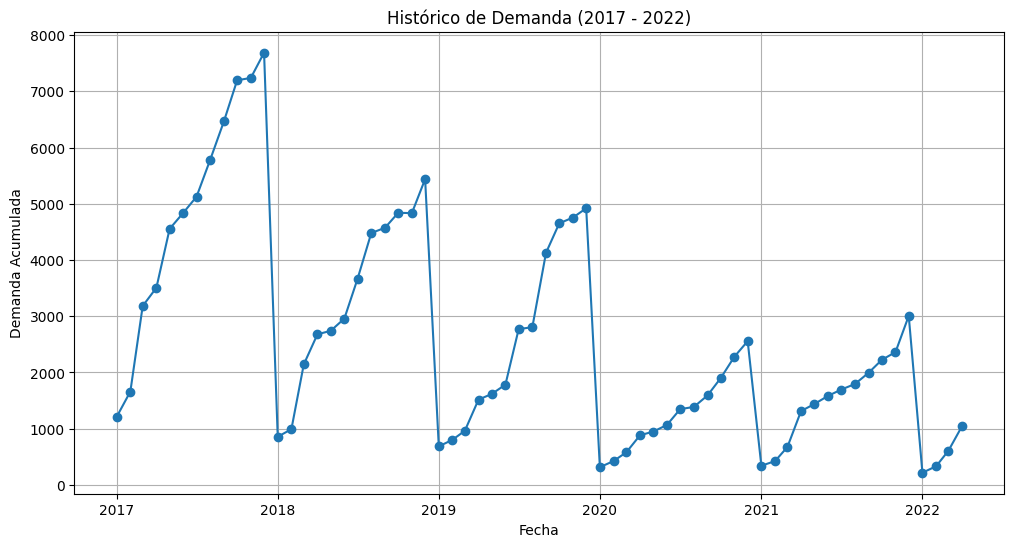

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_demand['year_month'], df_demand['Demand'], marker='o', linestyle='-')
plt.title('Histórico de Demanda (2017 - 2022)')
plt.xlabel('Fecha')
plt.ylabel('Demanda Acumulada')
plt.grid(True)
plt.show()

In [6]:
# ===============================
# 1. FEATURE ENGINEERING
# ===============================

df_full = df_demand.copy().sort_values("year_month")

# --- Variables de calendario ---
df_full["month"] = df_full["year_month"].dt.month
df_full["quarter"] = df_full["year_month"].dt.quarter
df_full["year"] = df_full["year_month"].dt.year
df_full["is_year_end"] = df_full["month"].isin([11, 12]).astype(int)

# --- Lags y diferencias ---
df_full["lag_1"] = df_full["Demand"].shift(1)
df_full["lag_12"] = df_full["Demand"].shift(12)
df_full["diff_1_2"] = df_full["lag_1"] - df_full["Demand"].shift(2)

# --- Rolling statistics ---
df_full["rolling_mean_3"] = df_full["Demand"].shift(1).rolling(3).mean()
df_full["rolling_mean_6"] = df_full["Demand"].shift(1).rolling(6).mean()
df_full["rolling_std_3"] = df_full["Demand"].shift(1).rolling(3).std()

# --- Variables avanzadas ---
df_full["rolling_cv_3"] = df_full["rolling_std_3"] / df_full["rolling_mean_3"]
df_full["trend_ratio"] = df_full["rolling_mean_3"] / df_full["rolling_mean_6"]
df_full["pct_change_1"] = df_full["Demand"].shift(1).pct_change()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import joblib

FEATURES_FINALES = [
    "month", 
    "quarter", 
    "year", 
    "is_year_end", 
    "rolling_std_3", 
    "trend_ratio"
]

def train_final_model(df):
    cols_to_use = FEATURES_FINALES + ["Demand", "year_month"]
    df_temp = df[cols_to_use].dropna().copy()
    
    train_size = int(len(df_temp) * 0.8)
    train = df_temp.iloc[:train_size]
    test = df_temp.iloc[train_size:]
    
    X_train, y_train = train[FEATURES_FINALES], train["Demand"]
    X_test, y_test = test[FEATURES_FINALES], test["Demand"]

    model = RandomForestRegressor(
        n_estimators=100, 
        max_depth=4, 
        random_state=42,
        min_samples_leaf=2
    )
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mae_relativo = (mae / y_train.mean()) * 100
    
    metrics = {
        "MAE": mae,
        "MAPE": mape,
        "R2": r2,
        "MAE_Relativo": mae_relativo
    }
    
    return model, metrics, test, preds

modelo_demanda, met_finales, df_test, y_preds = train_final_model(df_full)

print("MODELO DE DEMANDA ENTRENADO EXITOSAMENTE")
print("-" * 40)
print(f"R2 Score:     {met_finales['R2']:.4f}")
print(f"MAPE:         {met_finales['MAPE']:.2%}")
print(f"MAE:          {met_finales['MAE']:.2f}")
print(f"MAE Relativo: {met_finales['MAE_Relativo']:.2f}%")
print("-" * 40)

✅ MODELO DE DEMANDA ENTRENADO EXITOSAMENTE
----------------------------------------
R2 Score:     0.9405
MAPE:         22.08%
MAE:          161.57
MAE Relativo: 5.76%
----------------------------------------


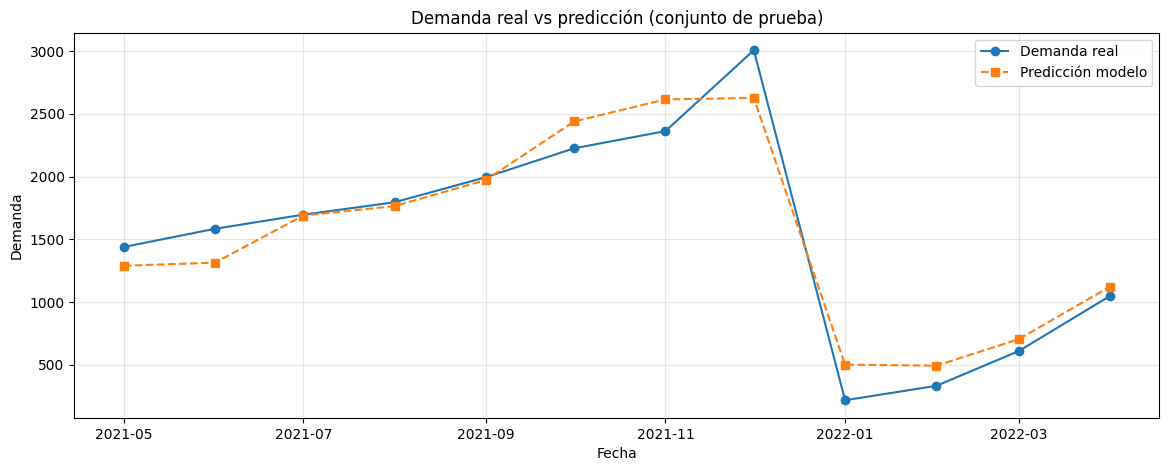

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 5))
plt.plot(df_test["year_month"], df_test["Demand"], label="Demanda real", marker="o") 
plt.plot(df_test["year_month"], y_preds, label="Predicción modelo", marker="s", linestyle="--")
plt.title("Demanda real vs predicción (conjunto de prueba)")
plt.xlabel("Fecha")
plt.ylabel("Demanda")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


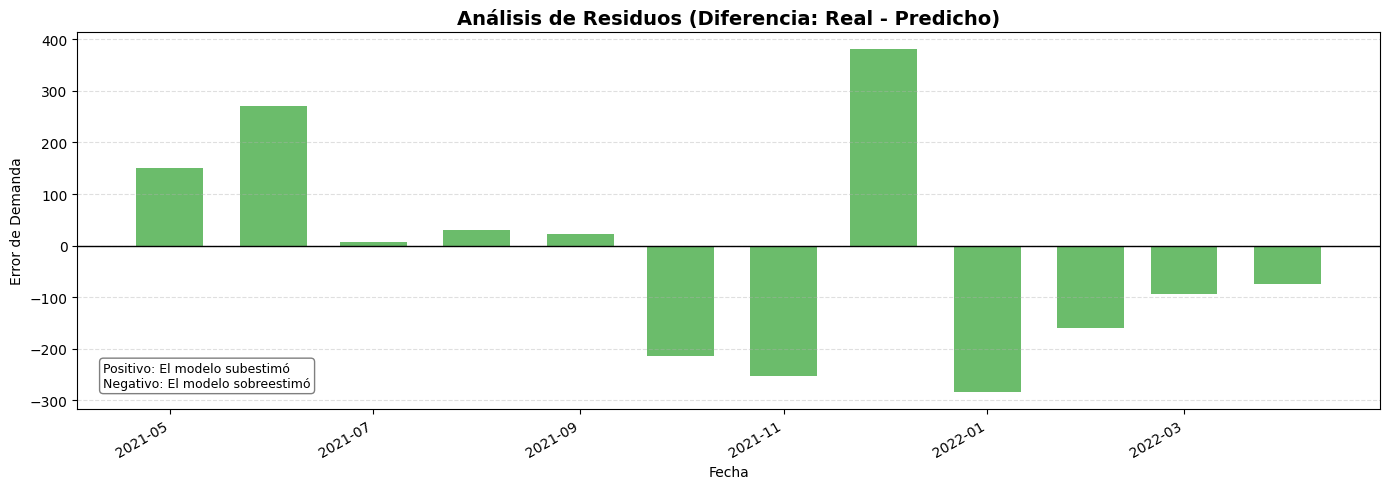

In [ ]:
residuos = df_test["Demand"] - y_preds

plt.figure(figsize=(14, 5))

plt.bar(df_test["year_month"], residuos, color='#2ca02c', alpha=0.7, width=20)

plt.axhline(0, color='black', linestyle='-', linewidth=1)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title("Análisis de Residuos (Diferencia: Real - Predicho)", fontsize=14, fontweight='bold')
plt.xlabel("Fecha")
plt.ylabel("Error de Demanda")
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.text(0.02, 0.05, "Positivo: El modelo subestimó\nNegativo: El modelo sobreestimó", 
         transform=plt.gca().transAxes, fontsize=9, verticalalignment='bottom', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [ ]:
def forecast_next_months(df_history, model, n_months=12):
    df_forecast = df_history.copy().sort_values("year_month")
    predictions = []

    for i in range(n_months):
        last_date = df_forecast["year_month"].iloc[-1]
        next_date = last_date + pd.DateOffset(months=1)

        month = next_date.month
        quarter = next_date.quarter
        year = next_date.year
        is_year_end = int(next_date.month in [11, 12])

        last_3 = df_forecast["Demand"].iloc[-3:]
        last_6 = df_forecast["Demand"].iloc[-6:]

        rolling_mean_3 = last_3.mean()
        rolling_mean_6 = last_6.mean()
        rolling_std_3 = last_3.std()
        
        trend_ratio = rolling_mean_3 / rolling_mean_6 if rolling_mean_6 != 0 else 1

        X_next = pd.DataFrame([{
            "month": month,
            "quarter": quarter,
            "year": year,
            "is_year_end": is_year_end,
            "rolling_std_3": rolling_std_3,
            "trend_ratio": trend_ratio
        }])

        pred = model.predict(X_next[FEATURES_FINALES])[0]

        predictions.append({
            "year_month": next_date,
            "Predicted_Demand": pred
        })

        df_forecast = pd.concat([
            df_forecast,
            pd.DataFrame([{
                "year_month": next_date,
                "Demand": pred
            }])
        ], ignore_index=True)

    return pd.DataFrame(predictions)

df_final_forecast = forecast_next_months(df_demand, modelo_demanda, n_months=12)
print(df_final_forecast.head())

  year_month  Predicted_Demand
0 2022-05-01             1,300
1 2022-06-01             1,309
2 2022-07-01             1,710
3 2022-08-01             1,868
4 2022-09-01             2,081


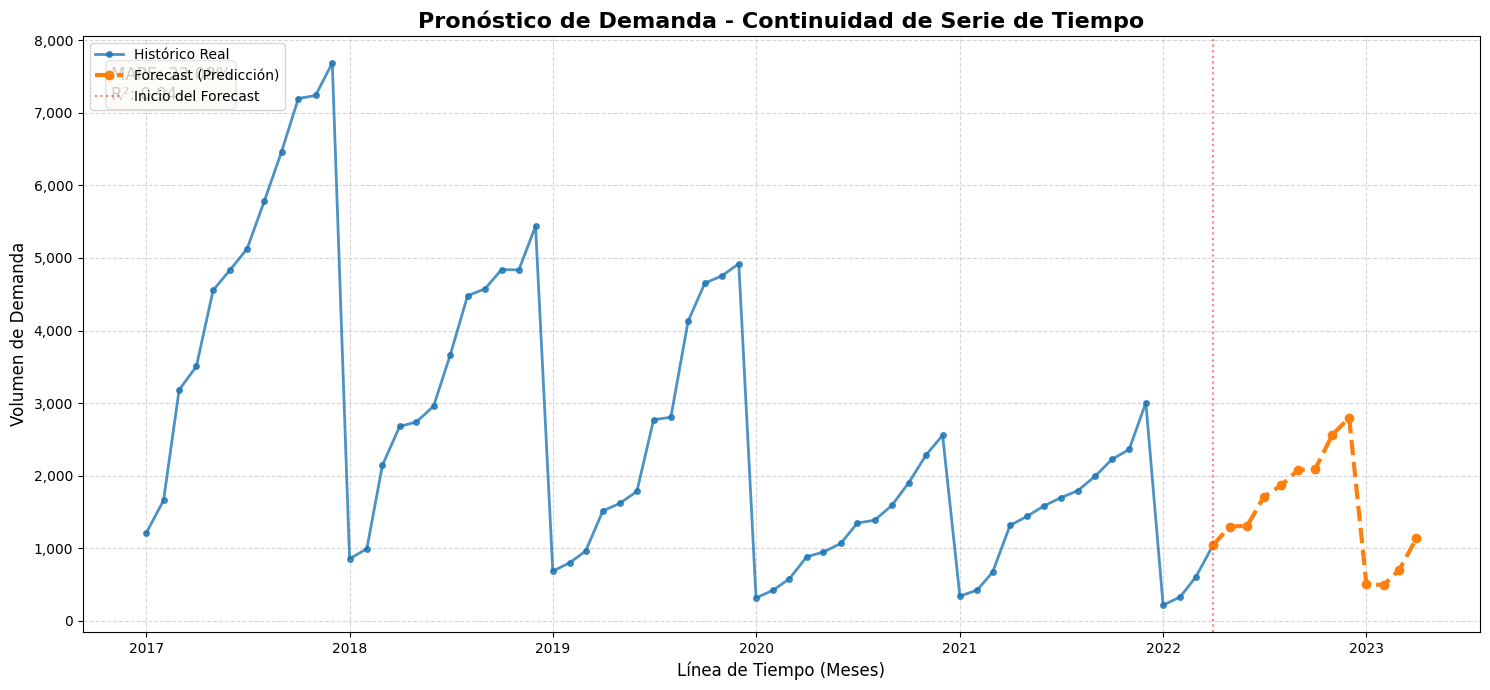

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

last_real_point = df_demand.tail(1)[['year_month', 'Demand']].copy()
last_real_point.columns = ['year_month', 'Predicted_Demand']


forecast_plot = pd.concat([last_real_point, df_final_forecast]).reset_index(drop=True)

plt.figure(figsize=(15, 7))

plt.plot(
    df_demand["year_month"], 
    df_demand["Demand"], 
    label="Histórico Real", 
    color='#1f77b4',
    linewidth=2,
    marker='o',
    markersize=4,
    alpha=0.8
)

plt.plot(
    forecast_plot["year_month"], 
    forecast_plot["Predicted_Demand"], 
    label="Forecast (Predicción)", 
    color='#ff7f0e', 
    linestyle="--", 
    linewidth=3,
    marker="o",
    markersize=6
)

textstr = '\n'.join((
    f'MAPE: {met_finales["MAPE"]:.2%}', 
    f'R²: {met_finales["R2"]:.2f}'
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', bbox=props)


plt.title("Pronóstico de Demanda - Continuidad de Serie de Tiempo", fontsize=16, fontweight='bold')
plt.xlabel("Línea de Tiempo (Meses)", fontsize=12)
plt.ylabel("Volumen de Demanda", fontsize=12)

plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))
)


plt.axvline(x=df_demand["year_month"].iloc[-1], color='red', linestyle=':', alpha=0.5, label='Inicio del Forecast')

plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd

pd.options.display.float_format = '{:.2f}'.format

meses_pedidos = ['2022-05-01', '2022-06-01', '2022-07-01']
df_target_forecast = df_final_forecast[df_final_forecast['year_month'].isin(pd.to_datetime(meses_pedidos))].copy()

print("--- Pronóstico de Demanda para Entrega ---")
print(df_target_forecast)



--- Pronóstico de Demanda para Entrega ---
  year_month  Predicted_Demand
0 2022-05-01           1300.06
1 2022-06-01           1309.21
2 2022-07-01           1709.79
